# **PROJETO APLICADO**



**MODELO EM CONSTRUÇÃO**

-*FALTA TUNING*

-*FALTA DETALHAR CADA ETAPA DO MODELO*

### Descrição do Problema

Este modelo consiste em aplicar técnicas de tratamento e PLN no pré processamento de Tweets relacionados ao mercado de ações brasileiro para sua posterior classificação através de um algortimo de classificação supervisionado.

Este modelo abrange a seguintes fases:

- Preparação dos dados
- Análise Exploratória
- Pré processamento
- Classificação
- Avaliação de Métricas
- Sintonização de Hiper parâmetros
- Exportação do modelo
- Testes

O arquivo pdf no diretório deste projeto ilustra de forma mais detalhada como foi as fases de criação e execução deste modelo

Referencias:

https://scikit-learn.org/stable/

https://dadosaocubo.com/nlp-com-scikit-learn/

In [2]:
#Variáveis Flags para setar trechos específicos do código que deve ou não serem executados
_LIB_LOAD = True #habilita/desabilita a carga das bibliotecas
_DATA_LOAD = True #habilita/desabilita a carga do dataset
_DEPLOY = False #habilita/desabilita a exportação do resultado do modelo 
_LEAVE_ONE_OUT_TRAIN = False #habilita/desabilita o treino pela técnica leave one out
_GRID_SEARCH_TRAIN = False #habilita/desabilita a sintonização pela técnica Grid Search
_RANDOM_SEARCH_TRAIN = False #habilita/desabilita a sintonização pela técnica Random Search
_NUMBER_OF_SAMPLES = 20000 #Define o número de amostras a serem carregadas do dataset

##Preparação dos Dados

### Carga das bibliotecas e dos dados

In [3]:
pip install six

In [4]:
#importando as bibliotecas
if _LIB_LOAD:
  import numpy as np #biblioteca para utilizacao de vetores e matrizes
  import pandas as pd #biblioteca para manipulação de dados
  import matplotlib.pyplot as plt #biblioteca para criar gráfpip install scikit-multilearnicos "comuns" ao estilo Matlab
  import seaborn as sns

  import nltk
  from nltk.stem.snowball import SnowballStemmer
  from nltk.corpus import stopwords
  nltk.download('stopwords')
  nltk.download('punkt')
  from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
  from imblearn.over_sampling import SMOTE

  from sklearn.svm import SVC
  from sklearn.svm import LinearSVC
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.linear_model import SGDClassifier

  from sklearn import metrics
  from sklearn.model_selection import train_test_split
  from sklearn.model_selection import KFold
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import LeaveOneOut

  from sklearn.model_selection import GridSearchCV
  from sklearn.metrics import f1_score, make_scorer
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import uniform

  from sklearn.metrics import confusion_matrix

  import pickle as pkl

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#liberando acesso do colab aos arquivos no drive
if _DATA_LOAD:
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#carregando os datasets
if _DATA_LOAD:
  df1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/data/NoThemeTweets.csv').sample(_NUMBER_OF_SAMPLES, random_state=42)
  df2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/data/tweets_stocks.csv')
  df3 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/data/tweets_ibovespa.csv')

Fonte: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis?select=NoThemeTweets.csv

Fonte: https://www.kaggle.com/fernandojvdasilva/stock-tweets-ptbr-emotions?select=tweets_stocks.csv


### Análise Exploratória 

In [7]:
# Amostra do dataframe
df1.head()

,id,tweet_text,tweet_date,sentiment,query_used
193377,1032462800571039744,eu to muito gordo :(,Thu Aug 23 03:01:28 +0000 2018,Negativo,:(
602080,1043227527479787522,"@nelsonfsilva8 actually same, continuo a mesma...",Fri Sep 21 19:56:39 +0000 2018,Positivo,:)
468421,1040799071055872000,meu vizinho pagou 600 reais num doguinho de ra...,Sat Sep 15 03:06:50 +0000 2018,Negativo,:(
448164,1040015296675950592,falar sobre política separa as pessoas :( fiqu...,Wed Sep 12 23:12:23 +0000 2018,Negativo,:(
190317,1032351066732539911,Jogo grátis STEAM: For Honor Está grátis por t...,Wed Aug 22 19:37:29 +0000 2018,Positivo,:)


In [8]:
# Dimensões (linhas x colunas) do dataframe
df1.shape

(20000, 5)

In [9]:
# Informações das variáveis do dataframe (nomes dos campos, quantidades nulas e não nulas, tipos de dados)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 193377 to 460693
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20000 non-null  int64 
 1   tweet_text  20000 non-null  object
 2   tweet_date  20000 non-null  object
 3   sentiment   20000 non-null  object
 4   query_used  20000 non-null  object
dtypes: int64(1), object(4)
memory usage: 937.5+ KB


In [10]:
# Numero de instâncias classificadas de cada tipo
df1['sentiment'].value_counts()

Negativo    13311
Positivo     6689
Name: sentiment, dtype: int64

In [11]:
# Estatísticas básicas das variáveis numéricas do dataframe
df1.describe(include="all")

,id,tweet_text,tweet_date,sentiment,query_used
count,2.000000e+04,20000,20000,20000,20000
unique,NaN,19963,19871,2,2
top,NaN,Bom dia :),Fri Sep 21 21:31:41 +0000 2018,Negativo,:(
freq,NaN,10,2,13311,13311
mean,1.038568e+18,NaN,NaN,NaN,NaN
std,5.540530e+15,NaN,NaN,NaN,NaN
min,1.029537e+18,NaN,NaN,NaN,NaN
25%,1.032450e+18,NaN,NaN,NaN,NaN
50%,1.039303e+18,NaN,NaN,NaN,NaN
75%,1.042970e+18,NaN,NaN,NaN,NaN


In [12]:
#somatório de dados faltantes por coluna
df1.isna().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

In [13]:
df1.isna().sum().any()

False

In [14]:
df1.groupby(["sentiment", "query_used"]).size()

sentiment  query_used
Negativo   :(            13311
Positivo   :)             6689
dtype: int64

### Pré-processamento dos dados

In [15]:
#duplicando nova coluna com o texto dos tweets que serão tratados
df1['new_text'] = df1['tweet_text'].copy()
#check
#df1.head()

Remover Pontuação

In [16]:
df1['new_text'] = df1['new_text'].str.replace('[,.:;!?]+', ' ', regex=True).copy()

Remover Caracteres especiais

In [17]:
df1['new_text'] = df1['new_text'].str.replace ('[/<>()|\+\-\$%&#@_\'\"]+', ' ', regex=True).copy()

Remover Números

In [18]:
df1['new_text'] = df1['new_text'].str.replace('[0-9]+', '', regex=True).copy()

Stemmer

In [19]:
# reduz cada palavra ao seu radical
stemmer = SnowballStemmer("portuguese")
#df1['new_text'] = df1['new_text'].apply(lambda x: [stemmer.stem(y) for y in x]).copy()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [20]:
df1['new_text'] = df1['new_text'].apply(stem_sentences)

In [21]:
df1['new_text'] = df1['new_text'].astype(str)
df1['new_text'] = df1['new_text'].str.lower()

Stop Words

In [22]:
#stop words são palavras que não agregam valor ao sentido da frase
# Lista com stop words da biblioteca NLTK
stop_words = stopwords.words('portuguese')

### Normalização dos dados

Mapeando a variável Target

In [23]:
#criando um dicionario de dados para o mapeamento
name_to_class = {
    'Negativo': 0,
    'Positivo': 1
}
#substituindo os valores categóricos pelo mapeamento
df1['sentiment'] = df1['sentiment'].map(name_to_class)

#check
#df1['sentiment'].value_counts()

Tokenização através do CountVectorizer

In [24]:
# Criação da função CountVectorizer
#Instancia o objeto que faz a vetorização dos dados de texto

#cvt = CountVectorizer(strip_accents='ascii', lowercase=True, ngram_range=(1, 3), stop_words=stop_words)

#from nltk.tokenize import TweetTokenizer
#tweet_tokenizer = TweetTokenizer()
#cvt = CountVectorizer(strip_accents='ascii', lowercase=True, ngram_range=(1, 3), stop_words=stop_words, analyzer="word", tokenizer=tweet_tokenizer.tokenize)

from nltk.tokenize import word_tokenize

cvt = CountVectorizer(strip_accents='ascii', lowercase=True, ngram_range=(1, 3), stop_words=stop_words, analyzer="word", tokenizer=word_tokenize)

In [25]:
X_cvt = cvt.fit_transform(df1['new_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
#print(cvt.get_feature_names())

In [26]:
# Criação da função TfidfTransformer
tfi = TfidfTransformer(use_idf=True)
X_tfi = tfi.fit_transform(X_cvt)
#X_tfi = tfi.fit(X_cvt)


Balanceamento dos dados

In [27]:
y = df1.loc[:,['sentiment']].values

In [28]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_tfi,y)

In [ ]:
np.bincount(y_res)

array([13311, 13311])

Dados

In [29]:
data = X_res
labels = y_res

##Modelos, Métricas e Validações

###Treino-Teste

Divisão

In [32]:

# aplicando a funcao train_test_split "Hand-out" para separar os conjuntos de treino e 
# teste segundo uma porcentagem de separação definida. 
# Separando 20% dos dados para teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state = 42)
# Separando para 20%, 30% e 40% dos dados para teste
#X_train1, X_test1, y_train1, y_test1 = train_test_split(data, labels, test_size=0.10, random_state = 42)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(data, labels, test_size=0.20, random_state = 42)
#X_train3, X_test3, y_train3, y_test3 = train_test_split(data, labels, test_size=0.30, random_state = 42)

####Modelos

#####Modelo 01

In [33]:
# Criando modelo
clf = LinearSVC()
#clf1 = LinearSVC()
#clf2 = LinearSVC()
#clf3 = LinearSVC()
# Treinamento do modelo
clf.fit(X_train, y_train)
#clf1.fit(X_train1, y_train1)
#clf2.fit(X_train2, y_train2)
#clf3.fit(X_train3, y_train3)

LinearSVC()

#####Modelo 02

In [34]:
# Criando modelo
mnb = MultinomialNB()
# Treinamento do modelo
mnb.fit(X_train, y_train)

MultinomialNB()

#####Modelo 03

In [35]:
# Criando e treinando o modelo 
rfc = RandomForestClassifier(n_estimators= 10, random_state=42).fit(X_train, y_train)

#####Modelo 04

In [36]:
# Criando modelo
knn = KNeighborsClassifier(n_neighbors=3)
# Treinamento do model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

#####Modelo 05

In [37]:
# Criando modelo
svm = SVC(kernel='sigmoid')
# Treinamento do modelo
svm.fit(X_train, y_train)
#kernel='rbf'
#kernel='sigmoid'


SVC(kernel='sigmoid')


####Predição e Métricas

#####Modelo 01

In [38]:
# Realizando a predição
predictions_clf = clf.predict(X_test)
#predictions_clf1 = clf1.predict(X_test1)
#predictions_clf2 = clf2.predict(X_test2)
#predictions_clf3 = clf3.predict(X_test3)

In [39]:
#avaliando o modelo 
print('Matriz de Confusão\n', metrics.confusion_matrix(y_test, predictions_clf)) 
print('\nAcurácia\n', metrics.accuracy_score(y_test, predictions_clf)) 
print('\nAcurácia Balanceada por classe\n', metrics.balanced_accuracy_score(y_test, predictions_clf)) 
print('\nPrecision\n', metrics.precision_score(y_test, predictions_clf)) 
print('\nRecall\n', metrics.recall_score(y_test, predictions_clf)) 
print('\nF1\n', metrics.f1_score(y_test, predictions_clf)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, predictions_clf))

Matriz de Confusão
 [[2395  313]
 [ 199 2418]]

Acurácia
 0.9038497652582159

Acurácia Balanceada por classe
 0.9041876374731967

Precision
 0.8853899670450385

Recall
 0.9239587313717997

F1
 0.9042632759910247

AUCROC
 0.9041876374731969


In [40]:
# Avaliação resumida
print(metrics.classification_report(y_test, predictions_clf))
#print(metrics.classification_report(y_test1, predictions_clf1))
#print(metrics.classification_report(y_test2, predictions_clf2))
#print(metrics.classification_report(y_test3, predictions_clf3))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2708
           1       0.89      0.92      0.90      2617

    accuracy                           0.90      5325
   macro avg       0.90      0.90      0.90      5325
weighted avg       0.90      0.90      0.90      5325



#####Modelo 02

In [41]:
# Realizando a predição
predictions_mnb = mnb.predict(X_test)

In [42]:
#avaliando o modelo 
print('Matriz de Confusão\n', metrics.confusion_matrix(y_test, predictions_mnb)) 
print('\nAcurácia\n', metrics.accuracy_score(y_test, predictions_mnb)) 
print('\nAcurácia Balanceada por classe\n', metrics.balanced_accuracy_score(y_test, predictions_mnb)) 
print('\nPrecision\n', metrics.precision_score(y_test, predictions_mnb)) 
print('\nRecall\n', metrics.recall_score(y_test, predictions_mnb)) 
print('\nF1\n', metrics.f1_score(y_test, predictions_mnb))
print('\nAUCROC\n', metrics.roc_auc_score(y_test, predictions_mnb))

Matriz de Confusão
 [[2123  585]
 [ 132 2485]]

Acurácia
 0.8653521126760564

Acurácia Balanceada por classe
 0.8667669888226566

Precision
 0.8094462540716613

Recall
 0.9495605655330531

F1
 0.8739229822401969

AUCROC
 0.8667669888226566


In [43]:
# Avaliação resumida
print(metrics.classification_report(y_test, predictions_mnb))

              precision    recall  f1-score   support

           0       0.94      0.78      0.86      2708
           1       0.81      0.95      0.87      2617

    accuracy                           0.87      5325
   macro avg       0.88      0.87      0.86      5325
weighted avg       0.88      0.87      0.86      5325



#####Modelo 03

In [44]:
# Realizando a predição
predictions_rfc = rfc.predict(X_test)

In [45]:
#avaliando o modelo 
print('Matriz de Confusão\n', metrics.confusion_matrix(y_test, predictions_rfc)) 
print('\nAcurácia\n', metrics.accuracy_score(y_test, predictions_rfc)) 
print('\nAcurácia Balanceada por classe\n', metrics.balanced_accuracy_score(y_test, predictions_rfc )) 
print('\nPrecision\n', metrics.precision_score(y_test, predictions_rfc)) 
print('\nRecall\n', metrics.recall_score(y_test, predictions_rfc)) 
print('\nF1\n', metrics.f1_score(y_test, predictions_rfc))
print('\nAUCROC\n', metrics.roc_auc_score(y_test, predictions_rfc))

Matriz de Confusão
 [[2477  231]
 [ 678 1939]]

Acurácia
 0.8292957746478873

Acurácia Balanceada por classe
 0.8278109582329829

Precision
 0.8935483870967742

Recall
 0.7409247229652274

F1
 0.810110716523919

AUCROC
 0.827810958232983


In [46]:
# Avaliação resumida
print(metrics.classification_report(y_test, predictions_rfc))

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      2708
           1       0.89      0.74      0.81      2617

    accuracy                           0.83      5325
   macro avg       0.84      0.83      0.83      5325
weighted avg       0.84      0.83      0.83      5325



#####Modelo 04

In [47]:
# Realizando a predição
predictions_knn = knn.predict(X_test)

In [48]:
#avaliando o modelo 
print('Matriz de Confusão\n', metrics.confusion_matrix(y_test, predictions_knn)) 
print('\nAcurácia\n', metrics.accuracy_score(y_test, predictions_knn)) 
print('\nAcurácia Balanceada por classe\n', metrics.balanced_accuracy_score(y_test, predictions_knn)) 
print('\nPrecision\n', metrics.precision_score(y_test, predictions_knn)) 
print('\nRecall\n', metrics.recall_score(y_test, predictions_knn)) 
print('\nF1\n', metrics.f1_score(y_test, predictions_knn))
print('\nAUCROC\n', metrics.roc_auc_score(y_test, predictions_knn))

Matriz de Confusão
 [[2700    8]
 [1292 1325]]

Acurácia
 0.755868544600939

Acurácia Balanceada por classe
 0.7516753597797381

Precision
 0.9939984996249063

Recall
 0.5063049293083683

F1
 0.670886075949367

AUCROC
 0.7516753597797381


In [49]:
# Avaliação resumida
print(metrics.classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      2708
           1       0.99      0.51      0.67      2617

    accuracy                           0.76      5325
   macro avg       0.84      0.75      0.74      5325
weighted avg       0.83      0.76      0.74      5325



#####Modelo 05

In [50]:
# Realizando a predição
predictions_svm = svm.predict(X_test)

In [51]:
#avaliando o modelo 
print('Matriz de Confusão\n', metrics.confusion_matrix(y_test, predictions_svm)) 
print('\nAcurácia\n', metrics.accuracy_score(y_test, predictions_svm)) 
print('\nAcurácia Balanceada por classe\n', metrics.balanced_accuracy_score(y_test, predictions_svm)) 
print('\nPrecision\n', metrics.precision_score(y_test, predictions_svm)) 
print('\nRecall\n', metrics.recall_score(y_test, predictions_svm)) 
print('\nF1\n', metrics.f1_score(y_test, predictions_svm))
print('\nAUCROC\n', metrics.roc_auc_score(y_test, predictions_svm))

Matriz de Confusão
 [[2404  304]
 [ 241 2376]]

Acurácia
 0.8976525821596244

Acurácia Balanceada por classe
 0.8978249249735708

Precision
 0.8865671641791045

Recall
 0.907909820405044

F1
 0.8971115725882576

AUCROC
 0.8978249249735708


In [52]:
# Avaliação resumida
print(metrics.classification_report(y_test, predictions_svm))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2708
           1       0.89      0.91      0.90      2617

    accuracy                           0.90      5325
   macro avg       0.90      0.90      0.90      5325
weighted avg       0.90      0.90      0.90      5325



###Validação Cruzada

In [53]:
# aplicando o modelo de validação cruzada
# divide o dataset entre 5 diferentes grupos
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

####Comparando Modelos

In [54]:
# construindo os modelos de classificação
modelos = [LinearSVC(), MultinomialNB(), RandomForestClassifier(n_estimators= 10),KNeighborsClassifier(n_neighbors=3),
           SVC(kernel='sigmoid'), DecisionTreeClassifier(), LogisticRegression(), SGDClassifier()]

In [55]:
#utilizando a validação cruzada
mean=[]
std=[]
for model in modelos:
    result = cross_val_score(model, data, labels, cv=kfold, scoring='f1', n_jobs=-1)
    mean.append(result)
    std.append(result)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

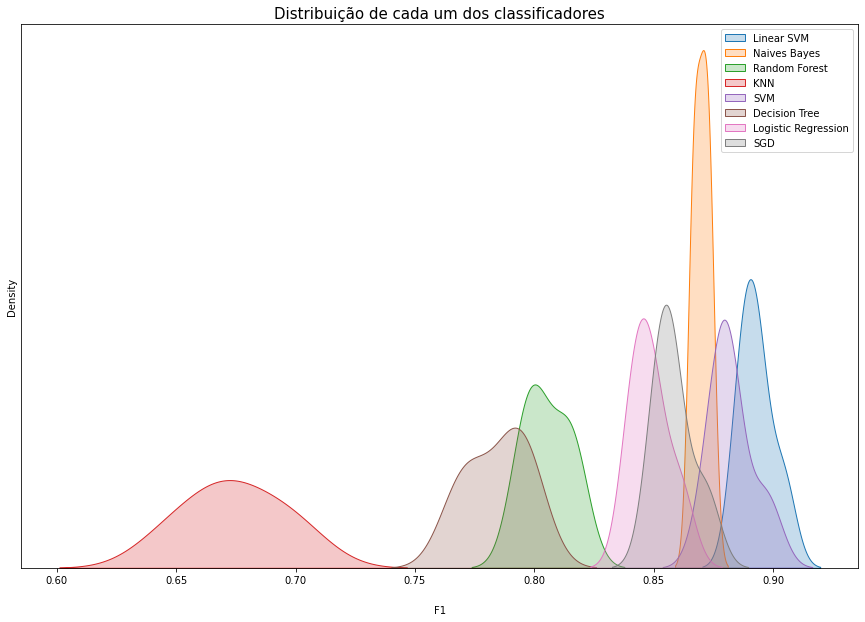

In [56]:
classificadores=['Linear SVM','Naives Bayes', 'Random Forest','KNN', 'SVM', 'Decision Tree', 'Logistic Regression', 'SGD']

plt.figure(figsize=(15, 10))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribuição de cada um dos classificadores", fontsize=15)
plt.legend(classificadores)
plt.xlabel("F1", labelpad=20)
plt.yticks([])

plt.show()

####Modelos

#####Modelo 01

In [ ]:
classifier_cv = SVC(kernel='sigmoid')
scores_cv = cross_val_score(classifier_cv, data, labels, cv=kfold)
scores_cv

Métricas

In [ ]:
print("Acurácia: %0.2f (+/- %0.2f)" % (scores_cv.mean(), scores_cv.std() * 2))

In [ ]:
scores_cv_precision = cross_val_score(classifier_cv, data, labels, cv=kfold, scoring='precision')
scores_cv_recall = cross_val_score(classifier_cv, data, labels, cv=kfold, scoring='recall')
scores_cv_f1 = cross_val_score(classifier_cv, data, labels, cv=kfold, scoring='f1')
scores_cv_aucroc = cross_val_score(classifier_cv, data, labels, cv=kfold, scoring='roc_auc')


print("Precision: %0.2f (+/- %0.2f)" % (scores_cv_precision.mean(), scores_cv_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_cv_recall.mean(), scores_cv_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores_cv_f1.mean(), scores_cv_f1.std() * 2))
print("AUCROC: %0.2f (+/- %0.2f)" % (scores_cv_aucroc.mean(), scores_cv_aucroc.std() * 2))

####Validação Cruzada com Estratificação

Modelo

In [ ]:
classifier_cv = LinearSVC()

cv_strat = StratifiedKFold(n_splits = 10)

scores_cv_strat = cross_val_score(classifier_cv, data, labels, cv=cv_strat)
scores_cv_strat_precision = cross_val_score(classifier_cv, data, labels, cv=cv_strat, scoring='precision')
scores_cv_strat_recall = cross_val_score(classifier_cv, data, labels, cv=cv_strat, scoring='recall')
scores_cv_strat_f1 = cross_val_score(classifier_cv, data, labels, cv=cv_strat, scoring='f1')

Métricas

In [ ]:
print("Acurácia: %0.2f (+/- %0.2f)" % (scores_cv_strat.mean(), scores_cv_strat.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_cv_strat_precision.mean(), scores_cv_strat_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_cv_strat_recall.mean(), scores_cv_strat_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores_cv_strat_f1.mean(), scores_cv_strat_f1.std() * 2))

####Leave One Out

In [ ]:
if _LEAVE_ONE_OUT_TRAIN : 
  classifier_cv = LinearSVC()

  loo = LeaveOneOut()

  scores_loo = cross_val_score(classifier_cv, data, labels, cv=loo)

  print("Acurácia: %0.2f (+/- %0.2f)" % (scores_loo.mean(), scores_loo.std() * 2))

###Sintonia de Hiperparâmetros

####Grid Search

grid search svm

In [ ]:
if _GRID_SEARCH_TRAIN:    
  #definindo hiperparâmetros
  hiperparam = {'kernel':('sigmoid', 'rbf'), 'C':[0.01, 1, 10]}

  #definindo o tipo de validacao cruzada e o numero de folds
  cv_strat = StratifiedKFold(n_splits = 10)

  #instânciando meu classificador
  classifier = SVC()

  #definindo a estrategia de score a partir da metrica f1
  f1 = make_scorer(f1_score)

  #instanciando e modelando o grid search com os hiperparametros e a validação definidas.
  grid_cv = GridSearchCV(classifier, hiperparam, cv = cv_strat, scoring = f1)
  grid_cv.fit(data, labels)

In [ ]:
if _GRID_SEARCH_TRAIN:      
  #vamos olhar para todos os resultados encontrados!
  print('Resumo de todos os resultados encontrados:\n\n', grid_cv.cv_results_)


In [ ]:
if _GRID_SEARCH_TRAIN:
  #vamos olhar para os melhores resultados encontrados pelo Grid Search
  print('Melhor resultado f1:', grid_cv.best_score_)
  print('\n\nMelhor configuração de hiperparâmetros:', grid_cv.best_params_)
  print( '\n\nConfigurações de todos os hiperparâmetros do melhor estimado encontrado pelo GridSearch: \n', grid_cv.best_estimator_)

grid serch random forest classifier

In [ ]:
#definindo hiperparâmetros
hiperparam = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


#definindo o tipo de validacao cruzada e o numero de folds
cv_strat = StratifiedKFold(n_splits = 10)

#instânciando meu classificador
classifier = RandomForestClassifier(random_state=42)

#definindo a estrategia de score a partir da metrica f1
f1 = make_scorer(f1_score)

#instanciando e modelando o grid search com os hiperparametros e a validação definidas.
grid_cv = GridSearchCV(classifier, hiperparam, cv = cv_strat, scoring = f1)
grid_cv.fit(data, labels)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                        

In [ ]:
#vamos olhar para todos os resultados encontrados!
print('Resumo de todos os resultados encontrados:\n\n', grid_cv.cv_results_)

Resumo de todos os resultados encontrados:

 {'mean_fit_time': array([ 4.31686747, 10.71769745,  4.24543548, 10.61512754,  1.059673  ,
        2.60577414,  5.13687396, 12.78645699,  5.14900203, 12.7441206 ,
        1.14523516,  2.80273633,  6.03746679, 15.18031225,  6.11566124,
       15.28577223,  1.25639446,  3.07845044,  7.06158934, 18.01097951,
        7.19916592, 17.80667827,  1.36630609,  3.34879649,  8.12946105,
       20.06571589,  8.09133365, 20.11463778,  1.4209739 ,  3.52276525,
        4.2207375 , 10.4596396 ,  4.17686493, 10.4329551 ,  1.03246291,
        2.53572474,  5.18079717, 12.83552175,  5.14468274, 12.82820697,
        1.12981501,  2.80145259,  6.06763117, 15.30204761,  6.05221989,
       15.11372783,  1.2195508 ,  3.00218942,  7.00972359, 17.50277603,
        7.00535994, 17.43657415,  1.31911678,  3.22587881,  7.93970115,
       19.83451335,  7.93380022, 19.83418021,  1.40904682,  3.49022117]), 'std_fit_time': array([0.0417422 , 0.13422792, 0.06090958, 0.06620958, 

In [ ]:
#vamos olhar para os melhores resultados encontrados pelo Grid Search
print('Melhor resultado f1:', grid_cv.best_score_)
print('\n\nMelhor configuração de hiperparâmetros:', grid_cv.best_params_)
print( '\n\nConfigurações de todos os hiperparâmetros do melhor estimado encontrado pelo GridSearch: \n', grid_cv.best_estimator_)

Melhor resultado f1: 0.6904742544917905


Melhor configuração de hiperparâmetros: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


Configurações de todos os hiperparâmetros do melhor estimado encontrado pelo GridSearch: 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


####Random Search

In [ ]:
if _RANDOM_SEARCH_TRAIN:
  #definindo o tipo de validacao cruzada e o numero de folds
  cv_strat = StratifiedKFold(n_splits = 10)

  #definindo a estrategia de score a partir da metrica f1
  f1 = make_scorer(f1_score)

  #definindo hiperparâmetros
  distributions = dict(kernel = ['sigmoid', 'rbf'], 
                      C = uniform(loc=0, scale=10))

  #instânciando meu classificador
  classifier = SVC()

  #instanciando e modelando o random search com os hiperparametros e a validação definidas.
  random_cv = RandomizedSearchCV(classifier, distributions, cv = cv_strat, scoring = f1, random_state = 42, n_iter = 10)
  random_cv.fit(data, labels)

In [ ]:
if _RANDOM_SEARCH_TRAIN:
  #vamos olhar para todos os resultados encontrados!
  print('Resumo de todos os resultados encontrados:\n\n', random_cv.cv_results_)

In [ ]:
if _RANDOM_SEARCH_TRAIN:
  #vamos olhar para os melhores resultados encontrados pelo Random Search
  print('Melhor resultado f1:', random_cv.best_score_)
  print('\n\nMelhor configuração de hiperparâmetros:', random_cv.best_params_)
  print( '\n\nConfigurações de todos os hiperparâmetros do melhor estimado encontrado pelo Random Search: \n', random_cv.best_estimator_)

##Exportação do Modelo

Melhor modelo encontrado - Parâmetros

In [ ]:
#Configurações de todos os hiperparâmetros do melhor estimado encontrado pelo Random Search: 
# modelo = SVC(C=3.745401188473625, break_ties=False, cache_size=200, class_weight=None,
#     coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
#     kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
#     shrinking=True, tol=0.001, verbose=False)

In [ ]:
#Configurações de todos os hiperparâmetros do melhor estimado encontrado pelo Random Search: 
modelo = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Divisão de treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state = 42)
modelo.fit(X_train, y_train)
predictions = modelo.predict(X_test)

In [ ]:
#avaliando o modelo 
print('Matriz de Confusão\n', metrics.confusion_matrix(y_test, predictions)) 
print('\nAcurácia\n', metrics.accuracy_score(y_test, predictions)) 
print('\nAcurácia Balanceada por classe\n', metrics.balanced_accuracy_score(y_test, predictions)) 
print('\nPrecision\n', metrics.precision_score(y_test, predictions)) 
print('\nRecall\n', metrics.recall_score(y_test, predictions)) 
print('\nF1\n', metrics.f1_score(y_test, predictions)) 
print('\nAUCROC\n', metrics.roc_auc_score(y_test, predictions))

Matriz de Confusão
 [[1093  257]
 [ 469  844]]

Acurácia
 0.7273751408186256

Acurácia Balanceada por classe
 0.7262161857211362

Precision
 0.7665758401453224

Recall
 0.6428027418126429

F1
 0.6992543496271749

AUCROC
 0.7262161857211362


###Pickle

In [ ]:
# Aplica o vetorizador nos dados de texto e retorna uma matriz esparsa ( contendo vários zeros):
if _DEPLOY:
    vec_file = '/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/vectorizer.pickle'
    pkl.dump(cvt, open(vec_file, 'wb'))
else:
    vec_file = '/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/vectorizer.pickle'
    pkl.dump(cvt, open(vec_file, 'wb'))
    vec_file = '/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/production/model/vectorizer.pickle'
    pkl.dump(cvt, open(vec_file, 'wb'))

In [ ]:
#Salva o modelo
if _DEPLOY:
    with open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modelo.pkl', 'wb') as model:
        pkl.dump(modelo, model) 
else:
    with open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modelo.pkl', 'wb') as model:
        pkl.dump(modelo, model) 
    with open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/production/model/modelo.pkl', 'wb') as model:
        pkl.dump(modelo, model) 

###Joblib

Salvar

In [ ]:
#salvar o modelo em formato joblib
#from joblib import dump, load

#dump(modelo, '/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modeljb.joblib') 

In [ ]:
#salvar os nomes das features do modelo simples
#datajb = X_train

#dump(datajb, '/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/featuresjb.names') 

Carregar

In [ ]:
#importar modelo e feature names
#new_model = load('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modeljb.joblib') 
#features = load('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/featuresjb.names') 

##Predições

Predição de frases positiva e negativa

In [ ]:
frase_positiva = "Feliz por ter encontrado o emprego dos meus sonhos, vou até fazer uma festa para comemorar essa conquista."
frase_negativa = "Infelizmente as coisas não saíram bem, levei prejuízo, acabei perdendo dinheiro, estou me sentido triste por isso."

In [ ]:
frase = []
frase.append(frase_positiva)
frase.append("\n")
frase.append(frase_negativa)

In [ ]:
frase = ''.join([i for i in frase if not i.isdigit()])
df_frase = pd.DataFrame([x.split(';') for x in frase.split('\n')])

df_frase.columns = ['text']
df_frase['new_text'] = df_frase['text'].str.replace('[,.:;!?]+', ' ', regex=True).copy()
df_frase['new_text'] = df_frase['new_text'].str.replace ('[/<>()|\+\-\$%&#@_\'\"]+', ' ', regex=True).copy()
df_frase['new_text'] = df_frase['new_text'].str.replace('[0-9]+', '', regex=True).copy()
df_frase['new_text'] = df_frase['new_text'].apply(stem_sentences)
df_frase['new_text'] = df_frase['new_text'].astype(str)
df_frase['new_text'] = df_frase['new_text'].str.lower()
dados_teste_frase = df_frase

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modelo.pkl', 'rb') as model:
  modelo_carregado = pkl.load(model)

testes = list(dados_teste_frase['new_text'])

vec = pkl.load(open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/vectorizer.pickle', 'rb'))
pred_cvt = vec.transform(testes)
pred_tfi = tfi.transform(pred_cvt)

resultado = modelo_carregado.predict(pred_tfi)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
resultado

array([1, 0])

Predição DataFrame df2

In [ ]:
#filtrando sentimentos positivos e negativos do segundo dataframe para testes posteriores

df2['sentiment'] =  np.where(df2['SAD'] == 1, 0, np.nan)
df2_negative = df2[df2['SAD']== 1]['text']
df2_negative = pd.DataFrame({'text':df2[df2['SAD']== 1]['text'], 'sentiment':df2[df2['SAD']== 1]['sentiment']})
df2['sentiment'] =  np.where(df2['JOY'] == 1, 1, np.nan)
df2_positive = df2[df2['JOY']== 1]['text']
df2_positive = pd.DataFrame({'text':df2[df2['JOY']== 1]['text'], 'sentiment':df2[df2['JOY']== 1]['sentiment']})
df2_concat = pd.concat([df2_positive, df2_negative])
df2_concat['new_text'] = df2_concat['text'].copy()
df2_concat.reset_index(drop=True, inplace=True)

In [ ]:
df2_concat['new_text'] = df2_concat['new_text'].str.replace('[,.:;!?]+', ' ', regex=True).copy()
df2_concat['new_text'] = df2_concat['new_text'].str.replace ('[/<>()|\+\-\$%&#@_\'\"]+', ' ', regex=True).copy()
df2_concat['new_text'] = df2_concat['new_text'].str.replace('[0-9]+', '', regex=True).copy()
df2_concat['new_text'] = df2_concat['new_text'].apply(stem_sentences)
df2_concat['new_text'] = df2_concat['new_text'].astype(str)
df2_concat['new_text'] = df2_concat['new_text'].str.lower()
dados_teste = df2_concat

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modelo.pkl', 'rb') as model:
  modelo_carregado = pkl.load(model)

testes = list(dados_teste['new_text'])

vec = pkl.load(open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/vectorizer.pickle', 'rb'))
pred_cvt = vec.transform(testes)
pred_tfi = tfi.transform(pred_cvt)

resultado = modelo_carregado.predict(pred_tfi)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
dados_teste['predito'] = resultado

prev_positivo = dados_teste['predito'].value_counts()[1]
prev_negativo = dados_teste['predito'].value_counts()[0]

real_positivo = dados_teste['sentiment'].value_counts()[1]
real_negativo = dados_teste['sentiment'].value_counts()[0]

y_act = list(dados_teste['sentiment'].astype(int))
y_pred = list(dados_teste['predito'].astype(int))

In [ ]:
real_negativo

437

In [ ]:
real_positivo

531

In [ ]:
# 1 = Positivo
# 0 = Negativo


matriz de confusão
            prev   prev
            Negativo    Positivo
real Negativo    437    490
real Positivo     478    531

Indicadores
* Acurácia: 50.00%
* Erros de classificação: 50.00%
* Positivos verdadeiros: 52.63%
* Falsos positivos: 52.86%
* Especificidade: 47.14%
* Precisão: 52.01%
* Prevalência: 52.12%


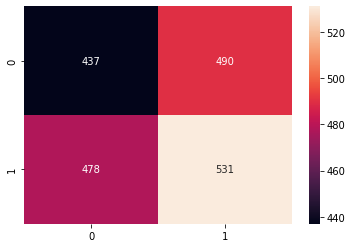

In [ ]:
cm = confusion_matrix(y_act, y_pred)
cm[0][0] = real_negativo
cm[0][1] = prev_positivo
cm[1][0] = prev_negativo
cm[1][1] = real_positivo 

print("\nmatriz de confusão")
print("            prev   prev")
print("            Negativo    Positivo")
print("real Negativo   %4d   %4d"%(cm[0][0], cm[0][1]))
print("real Positivo    %4d   %4d"%(cm[1][0], cm[1][1]))    

print("\nIndicadores")
print("* Acurácia: %.2f%%"%(100*(cm[0][0]+cm[1][1])/cm.sum()))
print("* Erros de classificação: %.2f%%"%(100*(cm[1][0]+cm[0][1])/cm.sum()))
print("* Positivos verdadeiros: %.2f%%"%(100*(cm[1][1])/(cm[1][0]+cm[1][1])))
print("* Falsos positivos: %.2f%%"%(100*(cm[0][1])/(cm[0][0]+cm[0][1])))
print("* Especificidade: %.2f%%"%(100*(cm[0][0])/(cm[0][0]+cm[0][1])))
print("* Precisão: %.2f%%"%(100*(cm[1][1])/(cm[0][1]+cm[1][1])))
print("* Prevalência: %.2f%%"%(100*(cm[1][0]+cm[1][1])/(cm.sum())))  


f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# cm = confusion_matrix(y_act, y_pred)
# cm[0][0] = prev_negativo
# cm[0][1] = prev_positivo
# cm[1][0] = real_positivo
# cm[1][1] = real_negativo

# f = sns.heatmap(cm, annot=True, fmt='d')

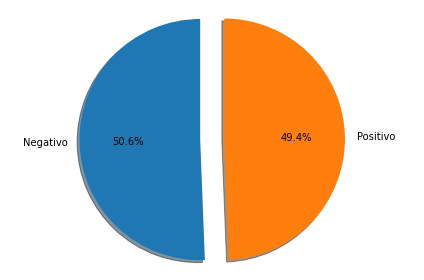

In [ ]:
negativo = dados_teste['predito'].map({1:'Positivo',0:'Negativo'}).value_counts()[0]
positivo = dados_teste['predito'].map({1:'Positivo',0:'Negativo'}).value_counts()[1]

# Gráfico Pizza Melhorado
labels = ['Negativo', 'Positivo']
sizes = [negativo,positivo]

explode = (0, 0.2)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Predição Dataframe df3

In [ ]:
df3.head()

,id,text,created_at
0,1437117868974432256,"RT @EricAmaral10: Dória é inescrupuloso, ele p...",Sun Sep 12 18:16:14 +0000 2021
1,1437117869393915904,RT @CNNBrasil: Capitais têm protestos contra o...,Sun Sep 12 18:16:15 +0000 2021
2,1437117869632991233,RT @revistaoeste: 12/09: A manifestação contra...,Sun Sep 12 18:16:15 +0000 2021
3,1437117870253748224,RT @Brisa43259555: Pra que tá chegando só agora,Sun Sep 12 18:16:15 +0000 2021
4,1437117870429904901,RT @LaurinhaIronic: URGENTE: Infelizmente o MB...,Sun Sep 12 18:16:15 +0000 2021


In [ ]:
df3['new_text'] = df3['text'].str.replace('[,.:;!?]+', ' ', regex=True).copy()
df3['new_text'] = df3['new_text'].str.replace ('[/<>()|\+\-\$%&#@_\'\"]+', ' ', regex=True).copy()
df3['new_text'] = df3['new_text'].str.replace('[0-9]+', '', regex=True).copy()
df3['new_text'] = df3['new_text'].apply(stem_sentences)
df3['new_text'] = df3['new_text'].astype(str)
df3['new_text'] = df3['new_text'].str.lower()
dados_teste_2 = df3

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/modelo.pkl', 'rb') as model:
  modelo_carregado = pkl.load(model)



testes = list(dados_teste_2['new_text'])

vec = pkl.load(open('/content/gdrive/My Drive/Colab Notebooks/Projeto Final IGTI/model/vectorizer.pickle', 'rb'))
pred_cvt = vec.transform(testes)
pred_tfi = tfi.transform(pred_cvt)

resultado = modelo_carregado.predict(pred_tfi)
dados_teste_2['predito'] = resultado

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
negativo = dados_teste_2['predito'].map({1:'Positivo',0:'Negativo'}).value_counts()[0]
positivo = dados_teste_2['predito'].map({1:'Positivo',0:'Negativo'}).value_counts()[1]
print(negativo)

2045


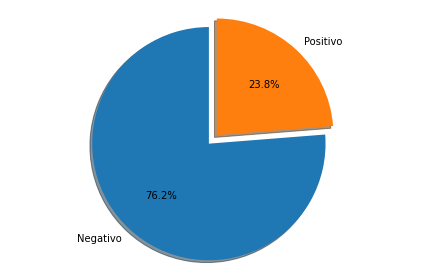

In [ ]:
negativo = dados_teste_2['predito'].map({1:'Positivo',0:'Negativo'}).value_counts()[0]
positivo = dados_teste_2['predito'].map({1:'Positivo',0:'Negativo'}).value_counts()[1]

# Gráfico Pizza Melhorado
labels = ['Negativo', 'Positivo']
sizes = [negativo,positivo]

explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()